# **BeReal - Product Analysis**

## Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

## Load Datasets

In [2]:
# Define filepath
d0_behaviours_filepath = '../datasets/d0_behaviour_br.csv'
retention_br_filepath = '../datasets/retention_br.csv'

In [3]:
# Load datasets
df__d0_behaviours = pd.read_csv(d0_behaviours_filepath, sep=';')
df__retention = pd.read_csv(retention_br_filepath, sep=';')

In [4]:
# Explore df__d0_behaviours shape
df__d0_behaviours.head()

,keychain_udid,country,os,locale,timezone,device_model,age,session_length,had_meaningful,install_at
0,secure_50a0754d419c6e3c,FI,Android,fi-FI,Europe/Helsinki,FNE-NX9,NaN,NaN,NaN,2023-12-05 10:32:31.472 UTC
1,secure_2782A0D3-0A38-422B-9CB6-28931970592D,US,iOS,en-US,America/Denver,"iPhone13,2",NaN,2.557,NaN,2023-12-05 22:48:35.932999 UTC
2,secure_0CD20425-8E3F-4D0B-A67F-D40CB10F34CD,CA,iOS,en-CA,America/Toronto,"iPhone11,8",NaN,NaN,NaN,2023-12-05 04:18:22.523 UTC
3,secure_622C90F7-AF79-493F-BB50-4E221132133B,US,iOS,en-US,America/New_York,"iPhone14,3",NaN,8.564,NaN,2023-12-05 22:20:19.751 UTC
4,secure_55EF1D64-A6BC-40CC-A54C-EBC8B0D80595,CA,iOS,en-CA,America/Edmonton,"iPhone15,2",NaN,11.709,NaN,2023-12-05 02:15:40.151 UTC


In [5]:
# Explore df__retention shape
df__retention.head()

,keychain_udid,d0,d3,d7,d14,d30
0,secure_43EDBC91-4589-43CF-A446-DC7265557A53,1,1,1,1,1
1,secure_89ED5A72-C861-48A4-AF21-28AC6AE74B43,1,1,1,0,1
2,secure_385E8185-2387-4B05-AD14-51BB3C4CCDDD,1,1,1,1,1
3,secure_C75E1926-FDCB-48FF-BCDF-371589ED2938,1,1,0,1,0
4,secure_7FAC8EC0-CF67-4DD0-9CEE-00C3C869ACB6,1,1,1,1,0


## Prepare Analysis Dataset

### d0_behaviour_br

In [6]:
# Standardise unique identifier
# Avoid missing the identification of duplicates and issues when merging datasets
df__d0_behaviours['keychain_udid'] = df__d0_behaviours['keychain_udid'].str.lower()

In [7]:
# Identify the number of exact duplicates based on keychain_udid
df__d0_behaviours.duplicated(subset='keychain_udid', keep=False).sum()

8

In [8]:
# Inspect the rows with duplicate keychain_udid
df__d0_behaviours[df__d0_behaviours.duplicated(subset='keychain_udid', keep=False)].sort_values('keychain_udid')

,keychain_udid,country,os,locale,timezone,device_model,age,session_length,had_meaningful,install_at
20771,secure_056ad6f273d1ed85,US,Android,en-US,America/New_York,Astro 55R,NaN,361.334000,NaN,2023-12-04 05:10:28.935 UTC
20790,secure_056ad6f273d1ed85,US,Android,en-US,America/New_York,Astro 55R,NaN,361.334000,NaN,2023-12-04 05:10:28.935 UTC
109514,secure_5dc009159444cd4a,GB,Android,en-GB,Europe/London,moto g(50),17.0,738.924001,0.0,2023-12-05 20:38:47.436 UTC
109616,secure_5dc009159444cd4a,GB,Android,en-GB,Europe/London,moto g(50),17.0,738.924001,0.0,2023-12-05 20:38:47.436 UTC
58109,secure_9f1fa2d1-41ae-4441-966e-285a0800444d,US,iOS,en-US,America/Phoenix,"iPhone13,2",15.0,2499.823000,0.0,2023-12-05 22:26:29.251 UTC
58131,secure_9f1fa2d1-41ae-4441-966e-285a0800444d,US,iOS,en-US,America/Phoenix,"iPhone13,2",15.0,2499.823000,0.0,2023-12-05 22:26:29.251 UTC
12480,secure_f87f0ec9864ae623,GB,Android,en-GB,Europe/London,SM-G950F,NaN,NaN,NaN,2023-12-01 16:42:27.256 UTC
12495,secure_f87f0ec9864ae623,GB,Android,en-GB,Europe/London,SM-G950F,NaN,NaN,NaN,2023-12-01 16:42:27.256 UTC


In [9]:
# Check for duplicates coming from app re-installs
# There are no such case in the dataset
df__d0_behaviours.groupby('keychain_udid')['install_at'].nunique().value_counts()

1    112766
Name: install_at, dtype: int64

In [10]:
# Remove exact duplicates based on keychain_udid
df__d0_behaviours = df__d0_behaviours.drop_duplicates(subset='keychain_udid', keep='first')

In [11]:
# Verify that the dataset is structured as one row per keychain_udid
len(df__d0_behaviours) - df__d0_behaviours['keychain_udid'].nunique()

0

In [12]:
# Check data types
df__d0_behaviours.dtypes

keychain_udid      object
country            object
os                 object
locale             object
timezone           object
device_model       object
age               float64
session_length    float64
had_meaningful    float64
install_at         object
dtype: object

In [13]:
# Cast install_at to datetime format
df__d0_behaviours['install_at'] = pd.to_datetime(df__d0_behaviours['install_at'])

In [14]:
# Check for missing values in all columns
missing_summary = df__d0_behaviours.isnull().sum().to_frame(name='missing_count')
missing_summary['missing_pct'] = (missing_summary['missing_count'] / len(df__d0_behaviours)) * 100
missing_summary = missing_summary.sort_values(by='missing_pct', ascending=False)
print(missing_summary)

                missing_count  missing_pct
had_meaningful          40444    35.865420
age                     30822    27.332707
session_length          10775     9.555185
locale                     13     0.011528
os                          6     0.005321
country                     2     0.001774
device_model                1     0.000887
keychain_udid               0     0.000000
timezone                    0     0.000000
install_at                  0     0.000000


In [15]:
# Check range of install_at
# There does not seem to be any outliers looking at the range of dates, we only have 5 days of installs data
df__d0_behaviours['install_at'].min(), df__d0_behaviours['install_at'].max()

(Timestamp('2023-12-01 00:00:06.264000+0000', tz='UTC'),
 Timestamp('2023-12-05 23:59:58.356000+0000', tz='UTC'))

In [16]:
# Explore unique values of categorical fields
print("=== OS ===")
print(df__d0_behaviours['os'].value_counts())
print("\n=== Country ===")
print(df__d0_behaviours['country'].value_counts())
print("\n=== Locale ===")
print(df__d0_behaviours['locale'].value_counts())

=== OS ===
iOS        72948
Android    39812
Name: os, dtype: int64

=== Country ===
US    60845
GB    15827
FR     6368
IT     4628
CA     4322
      ...  
GA        1
KN        1
IS        1
BI        1
MT        1
Name: country, Length: 196, dtype: int64

=== Locale ===
en-US    60407
en-GB    16161
fr-FR     6173
it-IT     4223
en-AU     3786
         ...  
es-CH        1
ar-IL        1
it-BR        1
en-NI        1
uk-CA        1
Name: locale, Length: 581, dtype: int64


In [17]:
# Detect outliers in session_length and age columns
# It's not expected to have sessions with a negative values, we will need to clean the relevant rows
# Despite maximum age being high (100), the range looks reasonable, it remains in the "possible" order of magnitudes
df__d0_behaviours[['session_length', 'age']].describe()

,session_length,age
count,101991.000000,81944.000000
mean,2134.425747,17.088634
std,3046.801101,4.069019
min,-5315.685000,13.000000
25%,192.959000,15.000000
50%,1056.586000,16.000000
75%,2809.271500,18.000000
max,51273.606000,100.000000


In [18]:
# Identify cases with a negative session_length
df__d0_behaviours[df__d0_behaviours['session_length'] < 0]

,keychain_udid,country,os,locale,timezone,device_model,age,session_length,had_meaningful,install_at
46421,secure_12b5e9200ec17294,US,Android,en-US,America/Los_Angeles,ONEPLUS A5000,19.0,-5315.685,1.0,2023-12-02 17:35:38.448000+00:00


In [19]:
# Given there is only one case, we will simply remove the row (not imputing values as we don't have the necessary inputs)
df__d0_behaviours = df__d0_behaviours[(df__d0_behaviours['session_length'].isna()) | (df__d0_behaviours['session_length'] >= 0)]

In [20]:
# Given BeReal target audience, we don't expect to have a large share of users above 30 years old
# The percentage from this age group is low, so we won't do any additional adjustment for this field
num_over_30 = df__d0_behaviours[df__d0_behaviours['age'] > 30].shape[0]
num_non_null_age = df__d0_behaviours['age'].notnull().sum()
pct_over_30 = (num_over_30 / num_non_null_age) * 100
print(f"Users over 30: {num_over_30} out of {num_non_null_age} ({pct_over_30:.2f}%)")

Users over 30: 1018 out of 81943 (1.24%)


In [21]:
# Replace NaN in had_meaningful column with 0s
df__d0_behaviours['had_meaningful'] = df__d0_behaviours['had_meaningful'].fillna(0)
df__d0_behaviours['had_meaningful'] = df__d0_behaviours['had_meaningful'].astype(int)

In [22]:
# Standardise further some columns to faciliate grouping (country, os, locale)
df__d0_behaviours['country'] = df__d0_behaviours['country'].str.strip().str.upper()
df__d0_behaviours['os'] = df__d0_behaviours['os'].str.strip().str.lower()
df__d0_behaviours['locale'] = df__d0_behaviours['locale'].str.strip().str.lower()

In [23]:
# Create additional columns to to prepare for grouped analyses and visualizations (world_region, age_group, session_length_bucket)
# We will refine the grouping structure later in the analysis if needed

# world_region
df__d0_behaviours['world_region'] = df__d0_behaviours['timezone'].str.split('/').str[0]

# age_group
def assign_age_group(age):
    if pd.isna(age):
        return 'Unknown'
    elif age <= 15:
        return '13–15'
    elif age <= 18:
        return '16–18'
    elif age <= 24:
        return '19–24'
    elif age <= 30:
        return '25–30'
    else:
        return '31+'

df__d0_behaviours['age_group'] = df__d0_behaviours['age'].apply(assign_age_group)

# bucket_session_length
def bucket_session_length(seconds):
    if pd.isna(seconds):
        return 'Unknown'
    elif seconds < 60:
        return '<1 min'
    elif seconds < 180:
        return '1–3 min'
    elif seconds < 300:
        return '3–5 min'
    else:
        return '>5 min'

df__d0_behaviours['bucket_session_length'] = df__d0_behaviours['session_length'].apply(bucket_session_length)

In [24]:
len(df__d0_behaviours)

112765

In [25]:
# Convert datetime to date to facilitate cohort analysis
# No need to go further in the grouping (weeks, month), given we only have 5 days of data
df__d0_behaviours['install_on'] = df__d0_behaviours['install_at'].dt.date

In [26]:
# Gather again summary infos from the dataset after data cleaning, standardisation and enrichment operations
df__d0_behaviours.head()

,keychain_udid,country,os,locale,timezone,device_model,age,session_length,had_meaningful,install_at,world_region,age_group,bucket_session_length,install_on
0,secure_50a0754d419c6e3c,FI,android,fi-fi,Europe/Helsinki,FNE-NX9,NaN,NaN,0,2023-12-05 10:32:31.472000+00:00,Europe,Unknown,Unknown,2023-12-05
1,secure_2782a0d3-0a38-422b-9cb6-28931970592d,US,ios,en-us,America/Denver,"iPhone13,2",NaN,2.557,0,2023-12-05 22:48:35.932999+00:00,America,Unknown,<1 min,2023-12-05
2,secure_0cd20425-8e3f-4d0b-a67f-d40cb10f34cd,CA,ios,en-ca,America/Toronto,"iPhone11,8",NaN,NaN,0,2023-12-05 04:18:22.523000+00:00,America,Unknown,Unknown,2023-12-05
3,secure_622c90f7-af79-493f-bb50-4e221132133b,US,ios,en-us,America/New_York,"iPhone14,3",NaN,8.564,0,2023-12-05 22:20:19.751000+00:00,America,Unknown,<1 min,2023-12-05
4,secure_55ef1d64-a6bc-40cc-a54c-ebc8b0d80595,CA,ios,en-ca,America/Edmonton,"iPhone15,2",NaN,11.709,0,2023-12-05 02:15:40.151000+00:00,America,Unknown,<1 min,2023-12-05


In [27]:
df__d0_behaviours.dtypes

keychain_udid                         object
country                               object
os                                    object
locale                                object
timezone                              object
device_model                          object
age                                  float64
session_length                       float64
had_meaningful                         int64
install_at               datetime64[ns, UTC]
world_region                          object
age_group                             object
bucket_session_length                 object
install_on                            object
dtype: object

In [28]:
missing_summary = df__d0_behaviours.isnull().sum().to_frame(name='missing_count')
missing_summary['missing_pct'] = (missing_summary['missing_count'] / len(df__d0_behaviours)) * 100
missing_summary = missing_summary.sort_values(by='missing_pct', ascending=False)
print(missing_summary)

                       missing_count  missing_pct
age                            30822    27.332949
session_length                 10775     9.555270
locale                            13     0.011528
os                                 6     0.005321
country                            2     0.001774
device_model                       1     0.000887
keychain_udid                      0     0.000000
timezone                           0     0.000000
had_meaningful                     0     0.000000
install_at                         0     0.000000
world_region                       0     0.000000
age_group                          0     0.000000
bucket_session_length              0     0.000000
install_on                         0     0.000000


### retention_br

In [29]:
# Standardise unique identifier
df__retention['keychain_udid'] = df__retention['keychain_udid'].str.lower()

In [30]:
# Check for duplicates
len(df__retention) - df__retention['keychain_udid'].nunique()

0

In [31]:
# Check data types
df__retention.dtypes

keychain_udid    object
d0                int64
d3                int64
d7                int64
d14               int64
d30               int64
dtype: object

In [32]:
# Check for missing values in all columns
missing_summary = df__retention.isnull().sum().to_frame(name='missing_count')
missing_summary['missing_pct'] = (missing_summary['missing_count'] / len(df__retention)) * 100
missing_summary = missing_summary.sort_values(by='missing_pct', ascending=False)
print(missing_summary)

               missing_count  missing_pct
keychain_udid              0          0.0
d0                         0          0.0
d3                         0          0.0
d7                         0          0.0
d14                        0          0.0
d30                        0          0.0


### Merged Datasets

In [33]:
# Merge datasets based on keychain_udid
df_analysis = df__d0_behaviours.merge(
    df__retention,
    on='keychain_udid',
    how='left'
)

In [34]:
# Fill missing values with 0s after the left join
retention_cols = ['d0', 'd3', 'd7', 'd14', 'd30']
df_analysis[retention_cols] = df_analysis[retention_cols].fillna(0)
df_analysis[retention_cols] = df_analysis[retention_cols].astype(int)

In [35]:
df_analysis.head()

,keychain_udid,country,os,locale,timezone,device_model,age,session_length,had_meaningful,install_at,world_region,age_group,bucket_session_length,install_on,d0,d3,d7,d14,d30
0,secure_50a0754d419c6e3c,FI,android,fi-fi,Europe/Helsinki,FNE-NX9,NaN,NaN,0,2023-12-05 10:32:31.472000+00:00,Europe,Unknown,Unknown,2023-12-05,0,0,0,0,0
1,secure_2782a0d3-0a38-422b-9cb6-28931970592d,US,ios,en-us,America/Denver,"iPhone13,2",NaN,2.557,0,2023-12-05 22:48:35.932999+00:00,America,Unknown,<1 min,2023-12-05,1,0,0,0,0
2,secure_0cd20425-8e3f-4d0b-a67f-d40cb10f34cd,CA,ios,en-ca,America/Toronto,"iPhone11,8",NaN,NaN,0,2023-12-05 04:18:22.523000+00:00,America,Unknown,Unknown,2023-12-05,0,0,0,0,0
3,secure_622c90f7-af79-493f-bb50-4e221132133b,US,ios,en-us,America/New_York,"iPhone14,3",NaN,8.564,0,2023-12-05 22:20:19.751000+00:00,America,Unknown,<1 min,2023-12-05,1,1,1,1,1
4,secure_55ef1d64-a6bc-40cc-a54c-ebc8b0d80595,CA,ios,en-ca,America/Edmonton,"iPhone15,2",NaN,11.709,0,2023-12-05 02:15:40.151000+00:00,America,Unknown,<1 min,2023-12-05,1,0,0,0,0


## Analysis

### Who are the users we are analysing?

In [36]:
# Total devices
print("=== 📱 Total Unique Devices ===")
total_devices = df_analysis['keychain_udid'].nunique()
print(f"{total_devices:,}\n")

# Function to format percentage output
def format_percentage_series(series, label):
    df = series.reset_index()
    df.columns = [label, 'Percentage (%)']
    return df

# OS Distribution
print("=== 💻 OS Distribution (%): ===")
os_percentage = df_analysis['os'].value_counts(normalize=True, dropna=False) * 100
os_table = format_percentage_series(os_percentage.round(2), 'OS')
print(os_table.to_string(index=False))
print()

# World Region Distribution
print("=== 🌍 World Region Distribution (%): ===")
region_percentage = df_analysis['world_region'].value_counts(normalize=True, dropna=False) * 100
region_table = format_percentage_series(region_percentage.round(2), 'World Region')
print(region_table.to_string(index=False))
print()

# Age Group Distribution
print("=== 👥 Age Group Distribution (%): ===")
age_group_percentage = df_analysis['age_group'].value_counts(normalize=True, dropna=False) * 100
age_table = format_percentage_series(age_group_percentage.round(2), 'Age Group')
print(age_table.to_string(index=False))

=== 📱 Total Unique Devices ===
112,765

=== 💻 OS Distribution (%): ===
     OS  Percentage (%)
    ios           64.69
android           35.30
    NaN            0.01

=== 🌍 World Region Distribution (%): ===
World Region  Percentage (%)
     America           55.79
      Europe           35.36
   Australia            3.45
          US            1.67
        Asia            1.64
      Africa            1.02
     Pacific            0.87
    Atlantic            0.11
      Indian            0.05
         Etc            0.03
         GMT            0.01
         UTC            0.00

=== 👥 Age Group Distribution (%): ===
Age Group  Percentage (%)
    16–18           29.46
  Unknown           27.33
    13–15           26.67
    19–24           14.80
      31+            0.90
    25–30            0.83


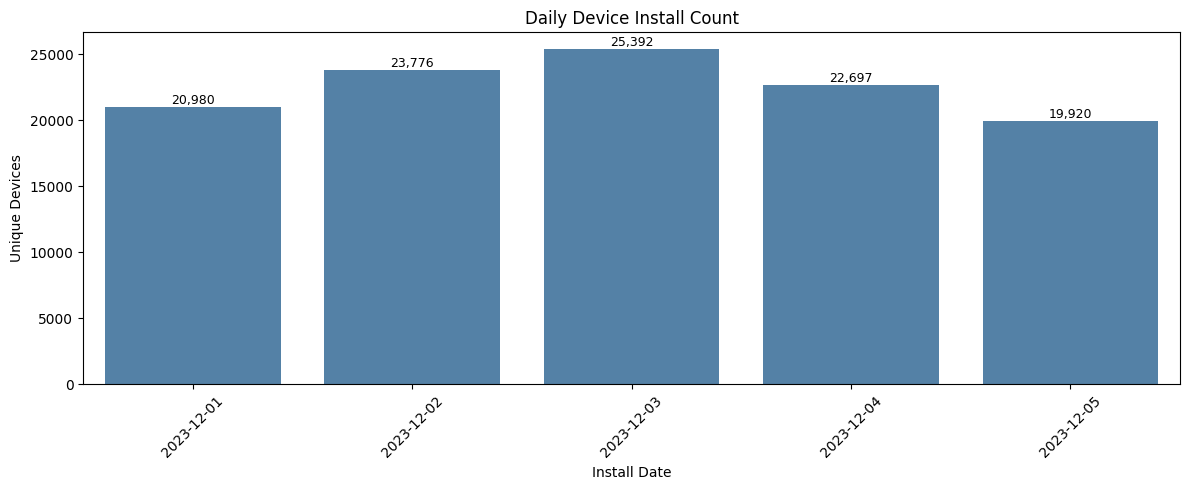

In [37]:
# Total Daily Installs

# Group installs by date
daily_device_installs_count = (
    df_analysis.groupby('install_on')['keychain_udid']
    .nunique()
    .reset_index(name='device_count')
)

# Create barplot
plt.figure(figsize=(12, 5))
ax = sns.barplot(
    data=daily_device_installs_count,
    x='install_on',
    y='device_count',
    color='steelblue'
)

# Add labels
for index, row in daily_device_installs_count.iterrows():
    ax.text(
        x=index,
        y=row['device_count'] + 0.5,
        s=f"{row['device_count']:,}",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.title('Daily Device Install Count')
plt.xlabel('Install Date')
plt.ylabel('Unique Devices')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
def plot_daily_installs_by_segment(df, segment_col):
    # Group installs by date and segment
    daily_installs = (
        df.groupby(['install_on', segment_col])['keychain_udid']
        .nunique()
        .reset_index(name='device_count')
    )

    # Create pivot table
    installs_table = daily_installs.pivot(
        index='install_on', columns=segment_col, values='device_count'
    ).fillna(0).astype(int)

    # Plot
    plt.figure(figsize=(14, 6))
    ax = sns.lineplot(
        data=daily_installs,
        x='install_on',
        y='device_count',
        hue=segment_col,
        marker='o'
    )

    # Format x-axis
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Label only the last point per segment
    last_points = daily_installs.sort_values('install_on').groupby(segment_col).tail(1)
    for _, row in last_points.iterrows():
        ax.text(
            row['install_on'],
            row['device_count'],
            f"{row['device_count']:,}",
            fontsize=9,
            va='bottom',
            ha='left'
        )

    # Final formatting
    plt.title(f'Daily Device Installs by {segment_col.replace("_", " ").title()}')
    plt.xlabel('Install Date')
    plt.ylabel('Unique Devices')
    plt.xticks(rotation=45)
    plt.legend(title=segment_col.replace('_', ' ').title(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Display pivot table
    print(f"\n📋 Daily Install Table by {segment_col.replace('_', ' ').title()}:\n")
    display(installs_table)

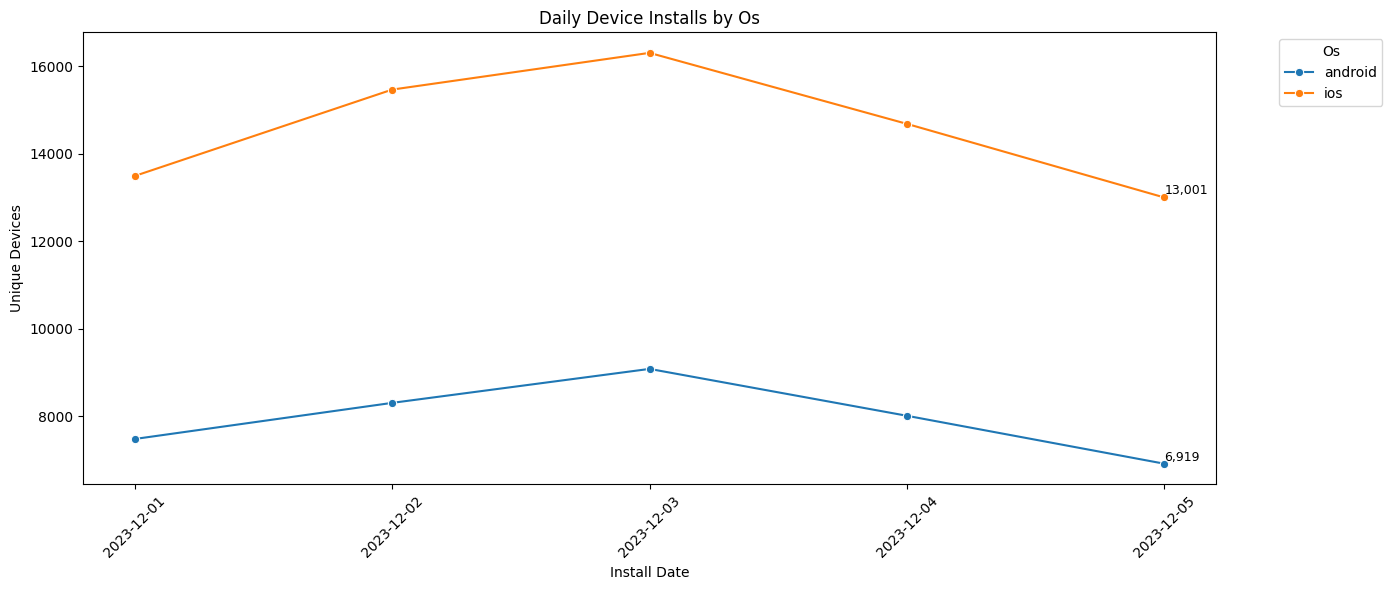


📋 Daily Install Table by Os:



os,android,ios
install_on,,
2023-12-01,7484,13493
2023-12-02,8309,15466
2023-12-03,9085,16305
2023-12-04,8014,14683
2023-12-05,6919,13001


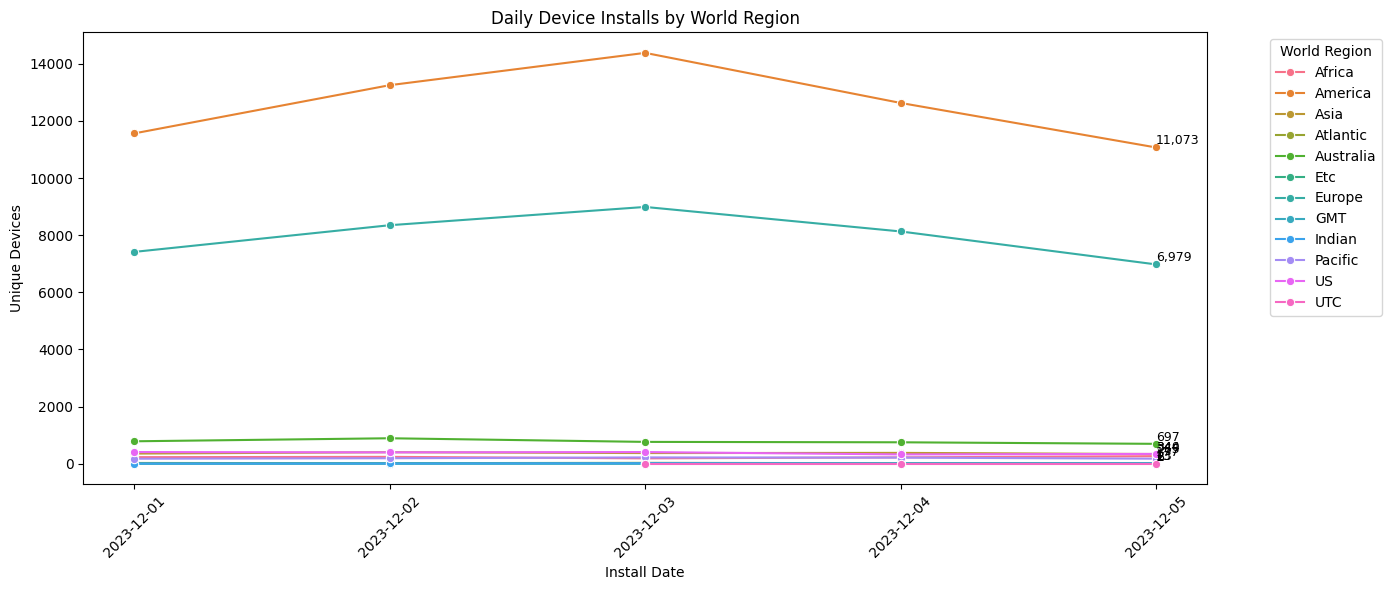


📋 Daily Install Table by World Region:



world_region,Africa,America,Asia,Atlantic,Australia,Etc,Europe,GMT,Indian,Pacific,US,UTC
install_on,,,,,,,,,,,,
2023-12-01,230,11566,356,27,786,4,7417,2,7,176,409,0
2023-12-02,241,13254,403,20,892,12,8351,2,9,193,399,0
2023-12-03,188,14385,374,31,765,7,8991,2,18,221,409,1
2023-12-04,223,12632,380,19,751,6,8133,4,8,214,326,1
2023-12-05,265,11073,340,23,697,6,6979,2,13,177,344,1


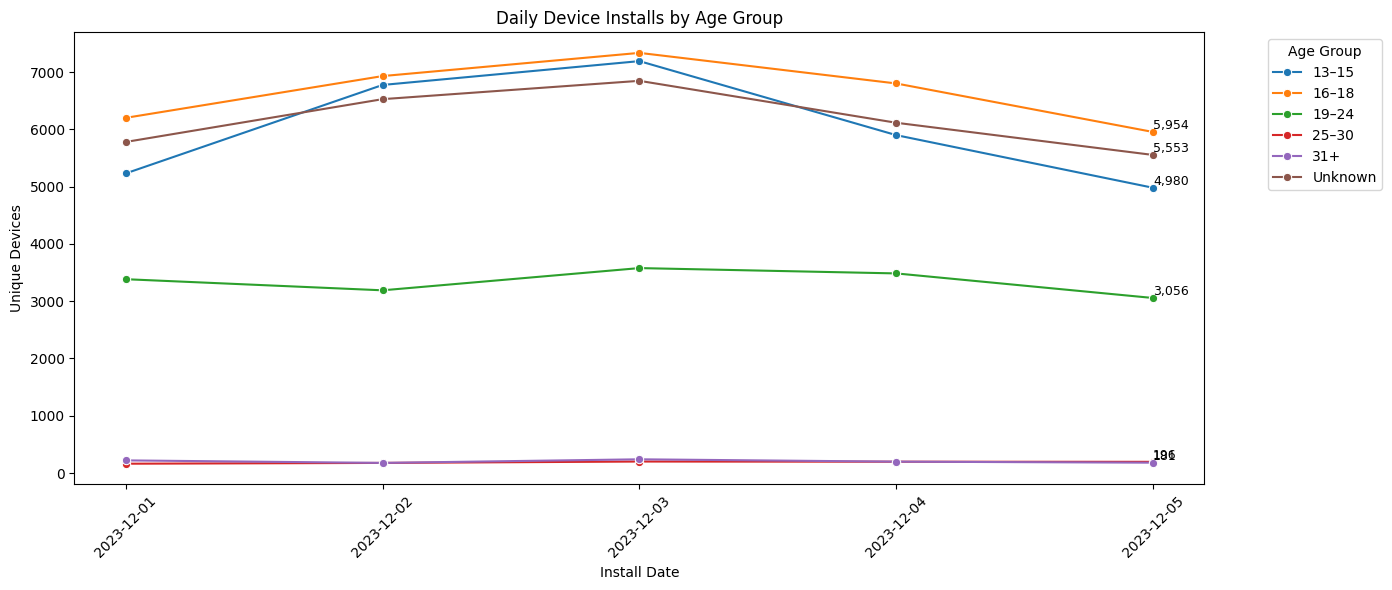


📋 Daily Install Table by Age Group:



age_group,13–15,16–18,19–24,25–30,31+,Unknown
install_on,,,,,,
2023-12-01,5231,6201,3384,163,221,5780
2023-12-02,6775,6930,3190,177,177,6527
2023-12-03,7191,7335,3578,201,240,6847
2023-12-04,5899,6801,3485,198,199,6115
2023-12-05,4980,5954,3056,196,181,5553


In [39]:
plot_daily_installs_by_segment(df_analysis, 'os')
plot_daily_installs_by_segment(df_analysis, 'world_region')
plot_daily_installs_by_segment(df_analysis, 'age_group')

### When and where do we observe retention issues?

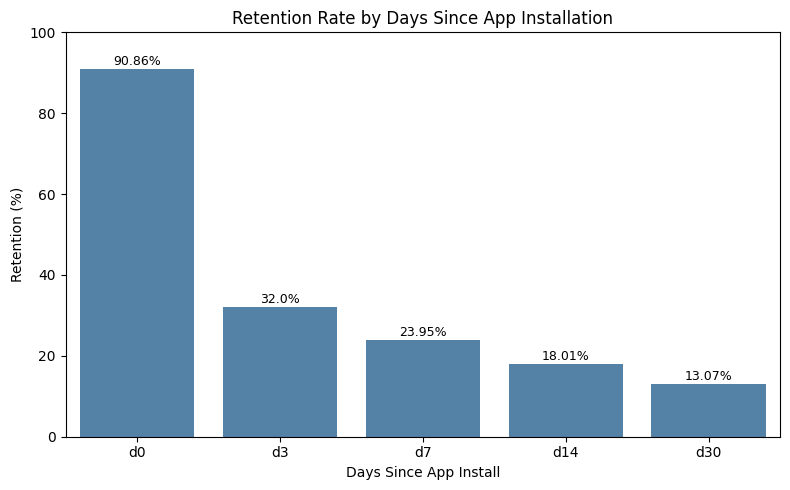

📋 Absolute Retained Device Counts:


,Day,Retained Devices
0,d0,102458
1,d3,36089
2,d7,27005
3,d14,20312
4,d30,14736


In [40]:
# Retention Rate by Lifecycle Stage
retention_cols = ['d0', 'd3', 'd7', 'd14', 'd30']

# Calculate absolute number of retained devices
retained_counts = (
    df_analysis[retention_cols]
    .sum()
    .astype(int)
    .reset_index()
    .rename(columns={'index': 'Day', 0: 'Retained Devices'})
)

# Calculate percentage of retained devices
retention_pct = (
    df_analysis[retention_cols]
    .mean()
    .mul(100)
    .round(2)
    .reset_index()
    .rename(columns={'index': 'Day', 0: 'Retention (%)'})
)

plt.figure(figsize=(8, 5))
sns.barplot(data=retention_pct, x='Day', y='Retention (%)', color='steelblue')

for index, row in retention_pct.iterrows():
    plt.text(index, row['Retention (%)'] + 1, f"{row['Retention (%)']}%", ha='center', fontsize=9)

plt.title('Retention Rate by Days Since App Installation')
plt.ylabel('Retention (%)')
plt.xlabel('Days Since App Install')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# Display table
print("📋 Absolute Retained Device Counts:")
display(retained_counts)

In [41]:
# Total installs = total number of rows (or unique devices if needed)
total_installs = len(df_analysis)

# Initialize drop-off list with Install → D0
d0_retained = df_analysis['d0'].sum()
install_to_d0_drop = (total_installs - d0_retained) / total_installs * 100

drop_off_pct = [round(install_to_d0_drop, 2)]

# Loop through remaining drop-offs (D0 → D3 → D7 → D14 → D30)
for i in range(len(retention_cols) - 1):
    current = df_analysis[retention_cols[i]].sum()
    next_ = df_analysis[retention_cols[i + 1]].sum()
    drop = (current - next_) / current * 100 if current > 0 else 0
    drop_off_pct.append(round(drop, 2))

# Assemble table
drop_off_table = pd.DataFrame({
    'From → To': ['Install → D0', 'D0 → D3', 'D3 → D7', 'D7 → D14', 'D14 → D30'],
    'Drop-off prev. stage (%)': drop_off_pct
})

display(drop_off_table)

,From → To,Drop-off prev. stage (%)
0,Install → D0,9.14
1,D0 → D3,64.78
2,D3 → D7,25.17
3,D7 → D14,24.78
4,D14 → D30,27.45


In [42]:
# Which user segments are most affected? (segment by installed_on, os, region_world, age_group)
def plot_segmented_retention(df, segment_col, retention_days=['d0', 'd3', 'd7', 'd14', 'd30']):
    # Step 1: Compute mean retention rates
    retention_by_segment = (
        df.groupby(segment_col)[retention_days]
        .mean()
        .reset_index()
    )

    # Step 2: Add total device count
    device_counts = df[segment_col].value_counts().rename('total_devices').reset_index().rename(columns={'index': segment_col})
    retention_by_segment = pd.merge(retention_by_segment, device_counts, on=segment_col)

    # Step 3: Rename retention rate columns
    renamed_cols = {day: f'%_retained_{day}' for day in retention_days}
    retention_by_segment = retention_by_segment.rename(columns=renamed_cols)

    # Step 4: Multiply rates by 100 and round
    for col in renamed_cols.values():
        retention_by_segment[col] = (retention_by_segment[col] * 100).round(2)

    # Step 5: Prepare for plotting
    plot_df = retention_by_segment.melt(
        id_vars=[segment_col],
        value_vars=list(renamed_cols.values()),
        var_name='Retention Day',
        value_name='Retention Rate'
    )
    plot_df['Retention Day'] = plot_df['Retention Day'].str.replace('%_retained_', '', regex=False)

    # Step 6: Plot line chart
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=plot_df, x='Retention Day', y='Retention Rate', hue=segment_col, marker='o')
    plt.ylabel('Retention (%)')
    plt.xlabel('Days since app installation')
    plt.ylim(0, 100)
    plt.title(f'Retention Rate by {segment_col.replace("_", " ").title()}')
    plt.legend(title=segment_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Step 7: Display % retention table
    print(f"\n📋 Retention Table by {segment_col} (as %):")
    display(retention_by_segment[[segment_col, 'total_devices'] + list(renamed_cols.values())])

    # Step 8: Compute and display absolute retained device counts
    absolute_retained = (
        df.groupby(segment_col)[retention_days]
        .sum()
        .astype(int)
        .reset_index()
        .reset_index(drop=True)
    )

    print(f"\n📊 Absolute Retained Devices by {segment_col}:")
    display(absolute_retained[[segment_col] + retention_days])

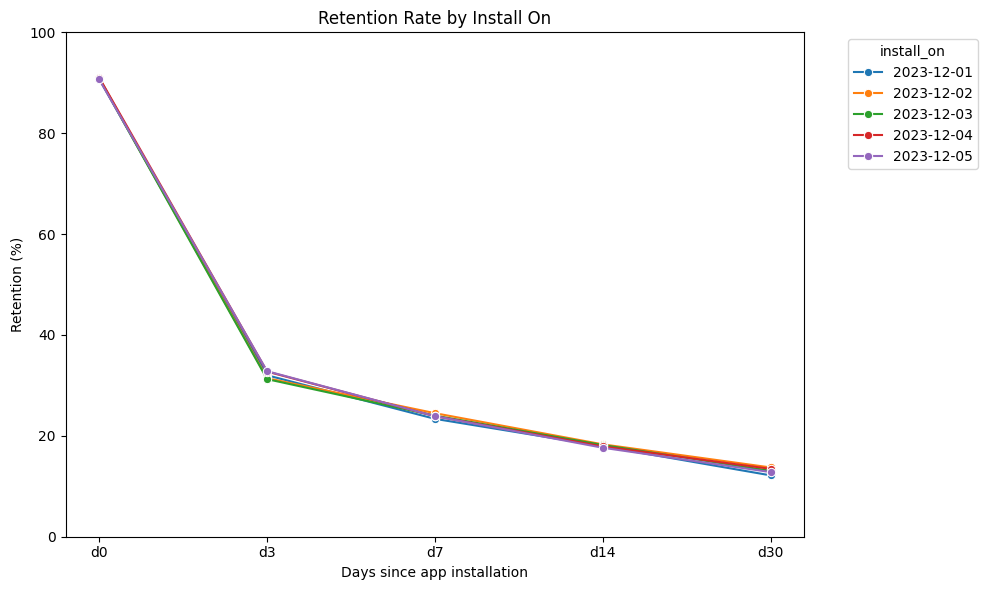


📋 Retention Table by install_on (as %):


,install_on,total_devices,%_retained_d0,%_retained_d3,%_retained_d7,%_retained_d14,%_retained_d30
0,2023-12-01,20980,90.76,32.01,23.37,17.94,12.16
1,2023-12-02,23776,90.98,31.43,24.49,18.31,13.73
2,2023-12-03,25392,90.86,31.24,24.00,18.18,13.06
3,2023-12-04,22697,91.02,32.74,23.90,17.90,13.45
4,2023-12-05,19920,90.65,32.82,23.90,17.64,12.81



📊 Absolute Retained Devices by install_on:


,install_on,d0,d3,d7,d14,d30
0,2023-12-01,19042,6715,4904,3764,2551
1,2023-12-02,21631,7472,5822,4354,3264
2,2023-12-03,23070,7932,6093,4617,3317
3,2023-12-04,20658,7432,5425,4063,3053
4,2023-12-05,18057,6538,4761,3514,2551


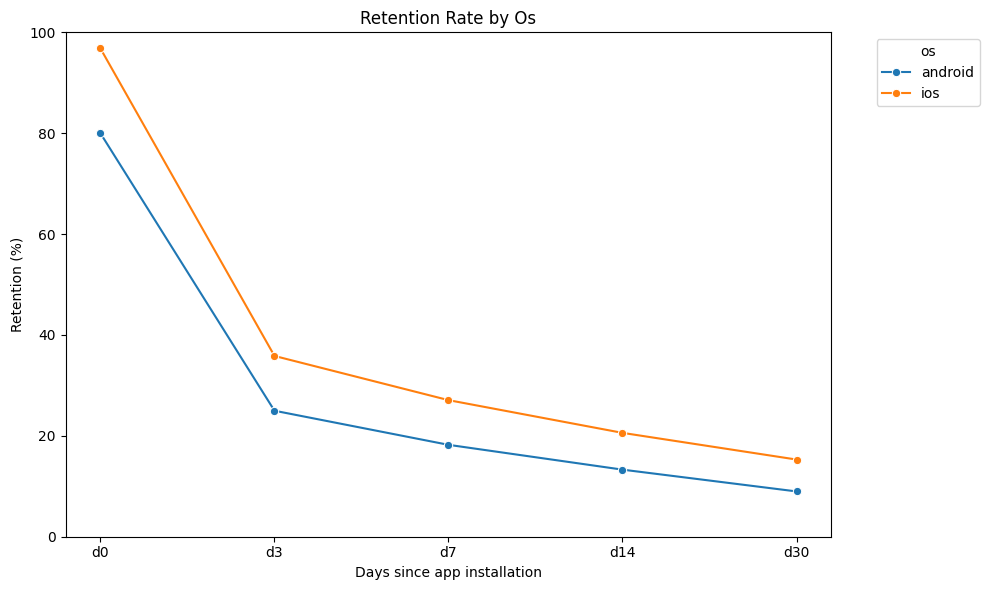


📋 Retention Table by os (as %):


,os,total_devices,%_retained_d0,%_retained_d3,%_retained_d7,%_retained_d14,%_retained_d30
0,android,39811,79.98,24.98,18.22,13.30,8.98
1,ios,72948,96.80,35.84,27.08,20.59,15.30



📊 Absolute Retained Devices by os:


,os,d0,d3,d7,d14,d30
0,android,31841,9946,7254,5294,3575
1,ios,70612,26143,19751,15018,11161


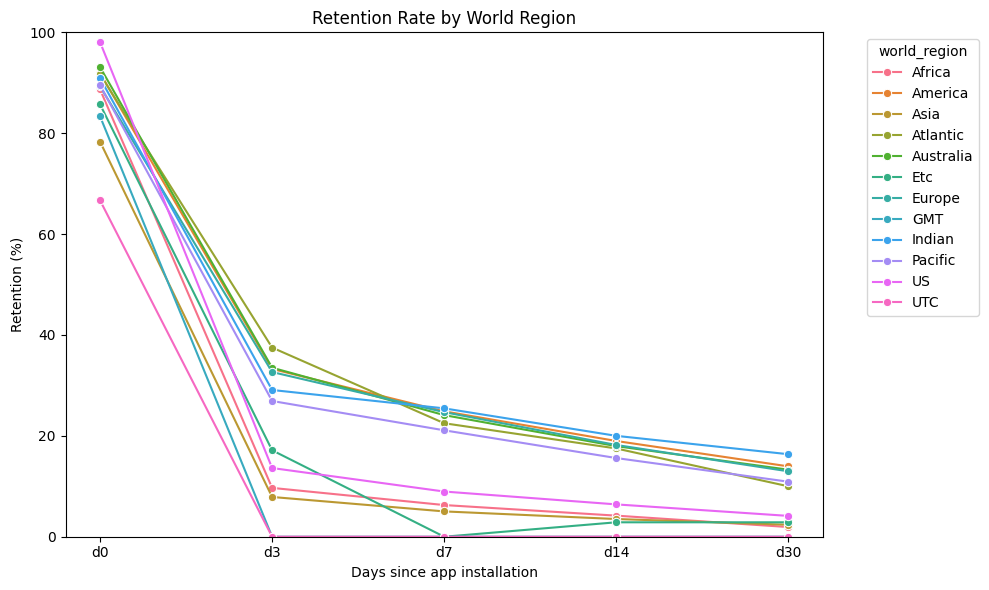


📋 Retention Table by world_region (as %):


,world_region,total_devices,%_retained_d0,%_retained_d3,%_retained_d7,%_retained_d14,%_retained_d30
0,Africa,1147,88.67,9.68,6.28,4.18,1.92
1,America,62910,91.93,33.26,24.86,18.98,13.95
2,Asia,1853,78.31,7.88,5.02,3.51,2.37
3,Atlantic,120,91.67,37.50,22.50,17.50,10.00
4,Australia,3891,93.09,33.51,24.11,17.96,13.29
5,Etc,35,85.71,17.14,0.00,2.86,2.86
6,Europe,39871,89.30,32.65,24.70,18.19,12.97
7,GMT,12,83.33,0.00,0.00,0.00,0.00
8,Indian,55,90.91,29.09,25.45,20.00,16.36
9,Pacific,981,89.50,26.91,21.10,15.60,10.91



📊 Absolute Retained Devices by world_region:


,world_region,d0,d3,d7,d14,d30
0,Africa,1017,111,72,48,22
1,America,57833,20924,15637,11939,8773
2,Asia,1451,146,93,65,44
3,Atlantic,110,45,27,21,12
4,Australia,3622,1304,938,699,517
5,Etc,30,6,0,1,1
6,Europe,35605,13016,9848,7254,5173
7,GMT,10,0,0,0,0
8,Indian,50,16,14,11,9
9,Pacific,878,264,207,153,107


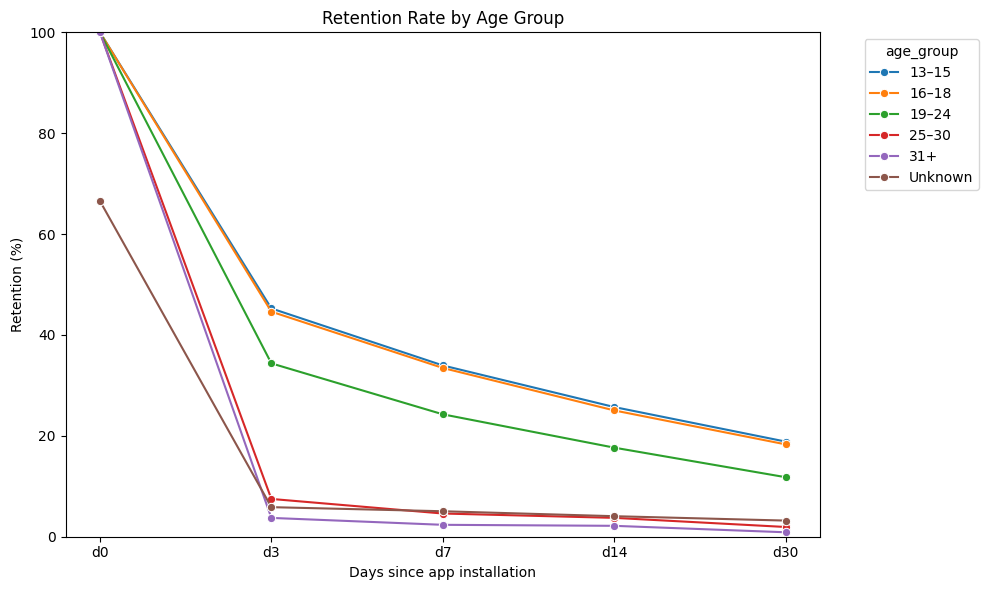


📋 Retention Table by age_group (as %):


,age_group,total_devices,%_retained_d0,%_retained_d3,%_retained_d7,%_retained_d14,%_retained_d30
0,13–15,30076,100.00,45.26,33.96,25.71,18.86
1,16–18,33221,100.00,44.62,33.46,25.04,18.31
2,19–24,16693,100.00,34.37,24.27,17.66,11.80
3,25–30,935,100.00,7.49,4.60,3.74,1.93
4,31+,1018,100.00,3.73,2.36,2.16,0.88
5,Unknown,30822,66.56,5.86,5.05,4.07,3.20



📊 Absolute Retained Devices by age_group:


,age_group,d0,d3,d7,d14,d30
0,13–15,30076,13613,10214,7733,5672
1,16–18,33221,14823,11117,8319,6083
2,19–24,16693,5738,4052,2948,1969
3,25–30,935,70,43,35,18
4,31+,1018,38,24,22,9
5,Unknown,20515,1807,1555,1255,985


In [43]:
plot_segmented_retention(df_analysis, 'install_on')
plot_segmented_retention(df_analysis, 'os')
plot_segmented_retention(df_analysis, 'world_region')
plot_segmented_retention(df_analysis, 'age_group')

### What behaviours drive or predict retention?

In [44]:
# Distribution of users with vs. without meaningful interaction
print("=== 💬 Had Meaningful Interaction Distribution (%): ===")
meaningful_pct = df_analysis['had_meaningful'].value_counts(normalize=True, dropna=False) * 100
meaningful_table = meaningful_pct.rename_axis('Had Meaningful').reset_index(name='Percentage (%)').round(2)
print(meaningful_table.to_string(index=False))
print()
# Distribution by session length bucket
print("=== ⏱️ Session Length Bucket Distribution (%): ===")
session_pct = df_analysis['bucket_session_length'].value_counts(normalize=True, dropna=False) * 100
session_table = session_pct.rename_axis('Session Length Bucket').reset_index(name='Percentage (%)').round(2)
print(session_table.to_string(index=False))
print()

=== 💬 Had Meaningful Interaction Distribution (%): ===
 Had Meaningful  Percentage (%)
              0           68.79
              1           31.21

=== ⏱️ Session Length Bucket Distribution (%): ===
Session Length Bucket  Percentage (%)
               >5 min           62.63
               <1 min           11.46
              1–3 min           10.34
              Unknown            9.56
              3–5 min            6.01



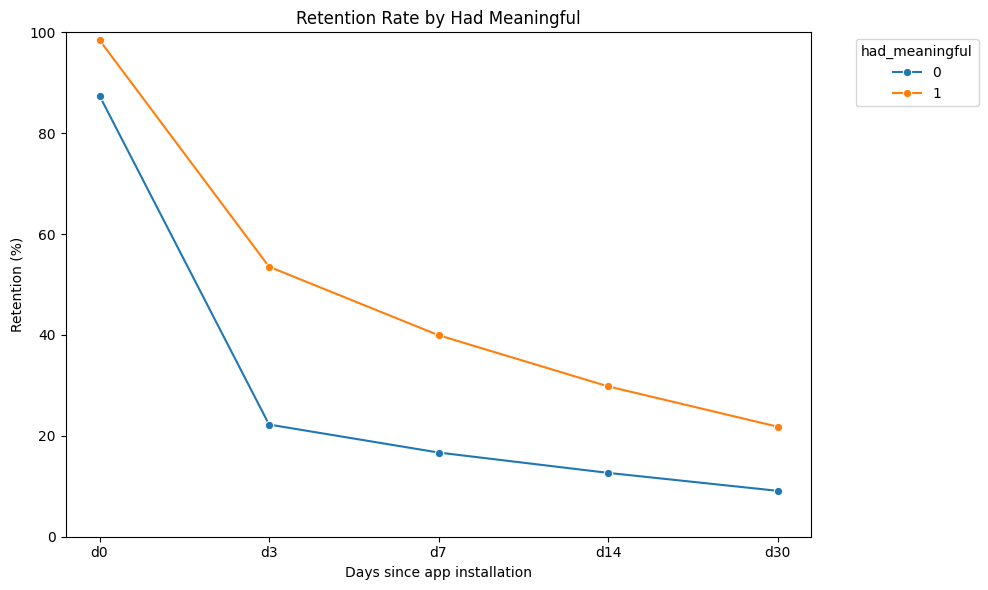


📋 Retention Table by had_meaningful (as %):


,had_meaningful,total_devices,%_retained_d0,%_retained_d3,%_retained_d7,%_retained_d14,%_retained_d30
0,0,77571,87.42,22.24,16.69,12.66,9.10
1,1,35194,98.45,53.53,39.95,29.81,21.82



📊 Absolute Retained Devices by had_meaningful:


,had_meaningful,d0,d3,d7,d14,d30
0,0,67810,17249,12944,9819,7056
1,1,34648,18840,14061,10493,7680


In [45]:
# Compare retention rates for users with vs. without had_meaningful = True
plot_segmented_retention(df_analysis, 'had_meaningful')

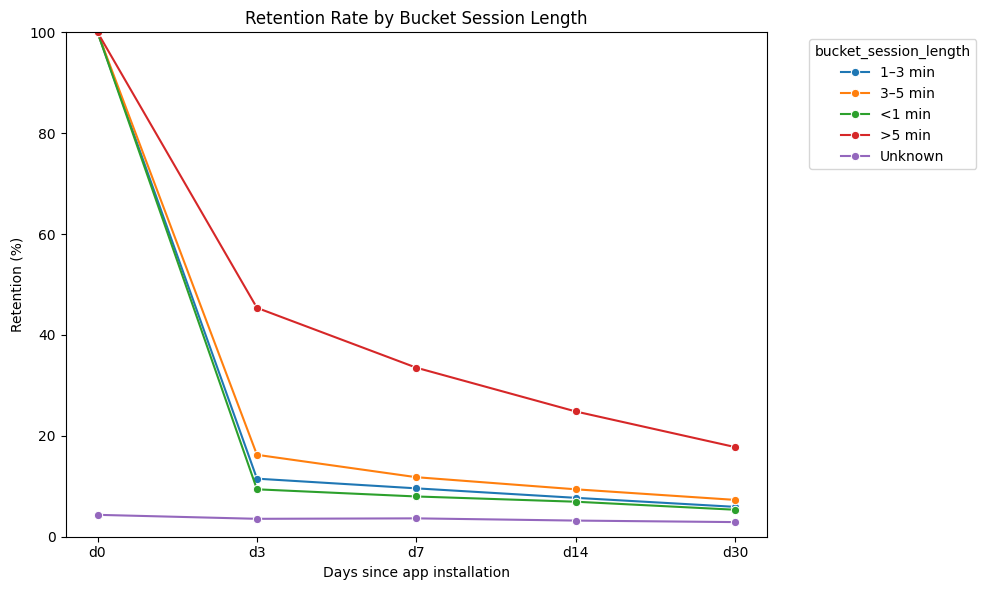


📋 Retention Table by bucket_session_length (as %):


,bucket_session_length,total_devices,%_retained_d0,%_retained_d3,%_retained_d7,%_retained_d14,%_retained_d30
0,1–3 min,11660,100.00,11.51,9.59,7.71,5.92
1,3–5 min,6778,100.00,16.24,11.80,9.40,7.30
2,<1 min,12924,100.00,9.40,7.98,6.94,5.35
3,>5 min,70628,100.00,45.38,33.51,24.83,17.77
4,Unknown,10775,4.34,3.55,3.64,3.20,2.90



📊 Absolute Retained Devices by bucket_session_length:


,bucket_session_length,d0,d3,d7,d14,d30
0,1–3 min,11660,1342,1118,899,690
1,3–5 min,6778,1101,800,637,495
2,<1 min,12924,1215,1031,897,691
3,>5 min,70628,32048,23664,17534,12548
4,Unknown,468,383,392,345,312


In [46]:
# Compare retention rates for users by session length
plot_segmented_retention(df_analysis, 'bucket_session_length')

In [ ]:
# Does a longer session lead to a meaningful interaction, or vice versa?
# Understand causality potential — does interaction extend sessions, or do longer sessions increase interaction likelihood?

In [47]:
# Check the average session length by had_meaningful to see if there's a difference
df_analysis.groupby('had_meaningful')['session_length'].describe()

,count,mean,std,min,25%,50%,75%,max
had_meaningful,,,,,,,,
0,67406.0,974.439612,1559.169339,0.000,94.0035,370.0150,1251.72150,51273.606
1,34584.0,4395.513983,3860.268127,0.222,1851.1325,3215.8195,5643.66375,46939.437


In [48]:
# Check what percentage in each bucket_session_length had had_meaningful = True
# % of meaningful interaction per session length bucket
interaction_likelihood = (
    df_analysis.groupby('bucket_session_length')['had_meaningful']
    .mean()
    .reset_index(name='pct_with_meaningful_interaction')
)

# Format as percentage
interaction_likelihood['pct_with_meaningful_interaction'] *= 100
interaction_likelihood.sort_values('bucket_session_length')

,bucket_session_length,pct_with_meaningful_interaction
0,1–3 min,1.046312
1,3–5 min,1.711419
2,<1 min,0.340452
3,>5 min,48.567141
4,Unknown,5.661253


/var/folders/gb/tfmtt9ld2t58rlx04v2m2p000000gq/T/ipykernel_95566/728501222.py:8: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_analysis


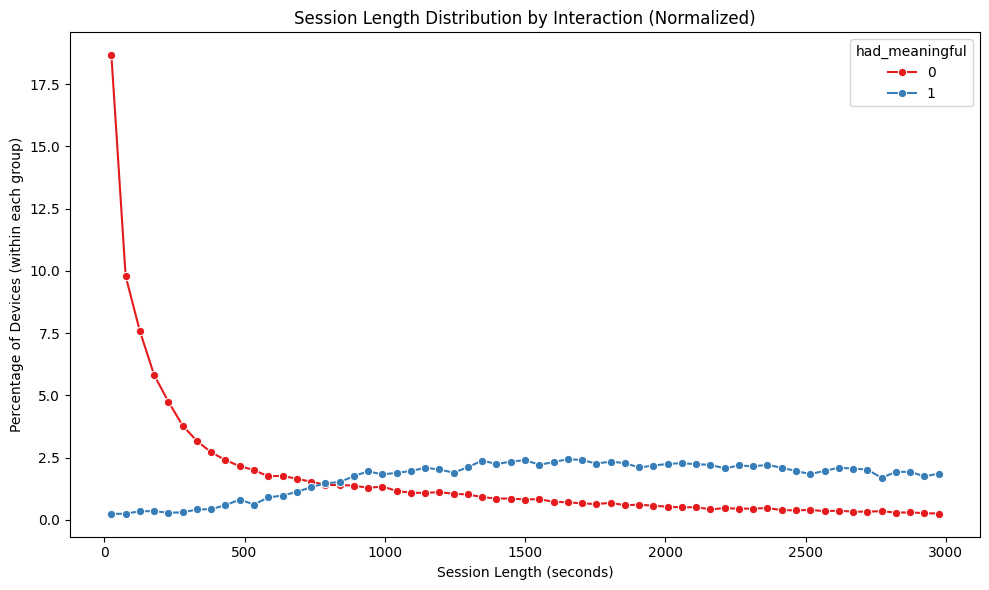

In [49]:
# Reverse the perspective: look at session length distributions for those with vs without meaningful interactions.
# Bin the session_length data
bins = np.linspace(0, 3000, 60) # creates 60 equally spaced bins between 0 and 3000 seconds
df_analysis['session_bin'] = pd.cut(df_analysis['session_length'], bins=bins) # assign each device to a session length bin.

# Calculate percentage distribution per bin for each group
session_distribution = (
    df_analysis
    .groupby(['had_meaningful', 'session_bin'])['keychain_udid']
    .count()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum()) # normalize each group (0 and 1) separately so that the total percentage across all bins for each group adds up to 100%
    .reset_index(name='percentage')
)

# Convert bin intervals to midpoints for plotting
session_distribution['bin_midpoint'] = session_distribution['session_bin'].apply(lambda x: x.mid)

# Plot as line chart
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=session_distribution,
    x='bin_midpoint',
    y='percentage',
    hue='had_meaningful',
    palette='Set1',
    marker='o'
)

plt.title('Session Length Distribution by Interaction (Normalized)')
plt.xlabel('Session Length (seconds)')
plt.ylabel('Percentage of Devices (within each group)')
plt.tight_layout()
plt.show()

In [50]:
# Create behavioural segments to faciliate proactive monitoring of cohorts early retention
# “Observers” – short session, no interactions
# “Explorers” – long session, no interactions
# “Engagers” – short session, early interaction
# “Power users” – long session + interaction

# Define what constitutes a long session (in seconds)
long_session_threshold = 300  # 5 minutes

# Normalize had_meaningful to boolean just in case
df_analysis['had_meaningful'] = df_analysis['had_meaningful'].astype(bool)

# Define behavior segments more robustly
def classify_behavior(row):
    session = row['session_length']
    interaction = row['had_meaningful']

    if pd.isna(session):
        return 'Unknown'
    
    if session < long_session_threshold:
        return 'Engagers' if interaction else 'Observers'
    else:
        return 'Power users' if interaction else 'Explorers'

# Apply segmentation
df_analysis['behavior_segment'] = df_analysis.apply(classify_behavior, axis=1)

In [51]:
# Sanity check: distribution of behaviours per behaviour segment had_meaningful
pd.crosstab(df_analysis['behavior_segment'], df_analysis['had_meaningful'], 
            rownames=['Behavior Segment'], 
            colnames=['Had Meaningful'])

Had Meaningful,False,True
Behavior Segment,,
Engagers,0,282
Explorers,36326,0
Observers,31080,0
Power users,0,34302
Unknown,10165,610


In [52]:
# Sanity check: distribution of behaviours per behaviour segment bucket_session_length
pd.crosstab(df_analysis['behavior_segment'], df_analysis['bucket_session_length'],
            rownames=['Behavior Segment'],
            colnames=['Session Length Bucket'])

Session Length Bucket,1–3 min,3–5 min,<1 min,>5 min,Unknown
Behavior Segment,,,,,
Engagers,122,116,44,0,0
Explorers,0,0,0,36326,0
Observers,11538,6662,12880,0,0
Power users,0,0,0,34302,0
Unknown,0,0,0,0,10775


In [53]:
# Compute and format behavior segment distribution
segment_dist = (
    df_analysis['behavior_segment']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .reset_index()
    .rename(columns={'index': 'Behavior Segment', 'behavior_segment': 'Percentage (%)'})
)

# Display the formatted table
print("📊 Behavior Segment Distribution (%):")
segment_dist

📊 Behavior Segment Distribution (%):


,Behavior Segment,Percentage (%)
0,Explorers,32.21
1,Power users,30.42
2,Observers,27.56
3,Unknown,9.56
4,Engagers,0.25


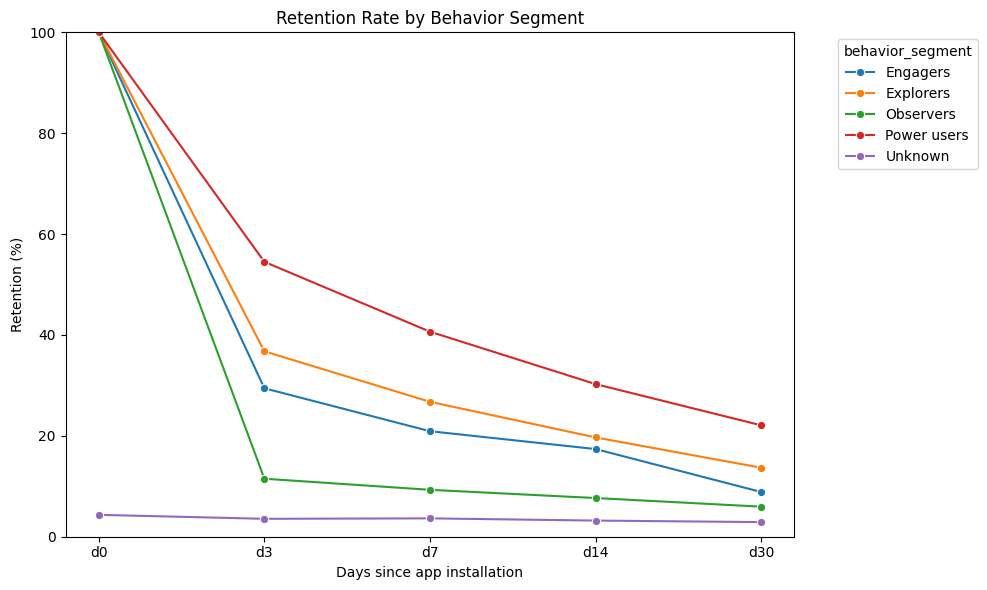


📋 Retention Table by behavior_segment (as %):


,behavior_segment,total_devices,%_retained_d0,%_retained_d3,%_retained_d7,%_retained_d14,%_retained_d30
0,Engagers,282,100.00,29.43,20.92,17.38,8.87
1,Explorers,36326,100.00,36.76,26.75,19.69,13.68
2,Observers,31080,100.00,11.50,9.30,7.67,5.96
3,Power users,34302,100.00,54.50,40.65,30.26,22.09
4,Unknown,10775,4.34,3.55,3.64,3.20,2.90



📊 Absolute Retained Devices by behavior_segment:


,behavior_segment,d0,d3,d7,d14,d30
0,Engagers,282,83,59,49,25
1,Explorers,36326,13353,9719,7153,4969
2,Observers,31080,3575,2890,2384,1851
3,Power users,34302,18695,13945,10381,7579
4,Unknown,468,383,392,345,312


In [54]:
# Compare retention rates for users by behaviour segment
plot_segmented_retention(df_analysis, 'behavior_segment')